In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.colors import ListedColormap
from skimage import io
from scipy.optimize import curve_fit

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

# import balance_configs as configs
import sac_mode_configs as configs
import experiments
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
# %matplotlib widget
%matplotlib ipympl
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = ""
model_path = os.path.join(base_path, "nmda_mult")
fig_dir_path = os.path.join(model_path, "figs") 
exts = [".png", ".svg"]

In [4]:
quanta_h5 = "quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
# target_rate_dt = 0.001  # 0.0001
target_rate_dt = 0.005  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2, # USUAL
    # spot=0.1, # CHANGED!
    # spot=0.05, # CHANGED!
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

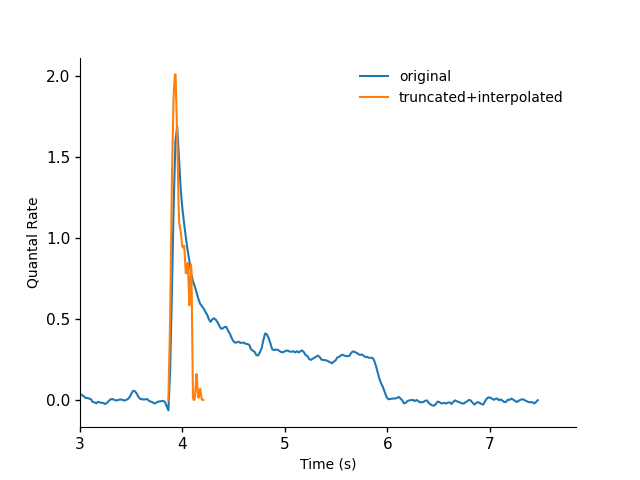

In [5]:
trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="truncated+interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [ ]:
overwrite = False

save_name = "thesis_nmda2x_eleak70_9n_5tr"

load_name = None

model_config = configs.thesis(
    ttx=False,
    non_ds_ach=False,
    offset_ampa_ach=False,
    poisson_rates={"sac": vrate / np.max(vrate), "glut": vrate / np.max(vrate), "dt": target_rate_dt},
    plexus=0,
    plexus_share=None,
    stacked_plex=False,
    record_tree=False, # TURN FALSE FOR RHO RANGE (more than 0 and 1)
    eleak=-70,  
)

model_config["synprops"]["NMDA"]["weight"] = model_config["synprops"]["NMDA"]["weight"] * 2

save_path = os.path.join(model_path, save_name) + ".h5"
if load_name is None:
    load_name = save_name
    if (not overwrite and os.path.exists(save_path)):
        print(
            "Loading %s rather than overwriting it.\nSet `overwrite = True` if saving over is desired."
            % save_name
        )
    else:
        from ei_balance_nogui import *
        os.makedirs(model_path, exist_ok=True)
        t0 = time.time()
        experiments.sacnet_titration_run(
            save_path,
            model_config,
            n_nets=9,
            n_trials=5,
            rho_steps=[0.0, 1.0],
            param_paths=[["synprops", "NMDA", "weight"]],
            titration_steps=[0.0, 1.0],
            pool_sz=6,
            reset_seed_between_rho=True,
        )
        print("rho run time:", time.time() - t0)

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
fig_path = os.path.join(fig_dir_path, load_name)
os.makedirs(fig_path, exist_ok=True)

factors = list(d.keys())
rhos = list(d[factors[0]].keys())
idxs = list(d[factors[0]][rhos[0]].keys())
print("==keys==")
print("factors:", factors)
print("rhos:", rhos)
print("idxs:", idxs)

In [7]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [8]:
factor_names = {0.0: "AP5", 1.0: "CTRL"}
metrics = {k: ana.get_sac_metrics(d[k]) for k in factors}

dir_labels = d[factors[0]][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
null_idx = np.argwhere(dir_labels == 180)[0][0]
pref_idx = np.argwhere(dir_labels == 0)[0][0]
sac_thetas = ana.get_sac_thetas(d[factors[0]])
sac_deltas = ana.get_sac_deltas(sac_thetas)
print("metrics:", metrics[factors[0]][rhos[0]].keys())

metrics: dict_keys(['spikes', 'thetas', 'DSis', 'avg_theta', 'avg_DSi'])


In [9]:
soma_vm = {
    factor: {
           rho: np.stack([d[factor][rho][net]["soma"]["Vm"] for net in idxs], axis=0)
           for rho in rhos
        }
        for factor in factors
    } 

vm_dt = d[factors[0]][rhos[0]][idxs[0]]["params"]["dt"]
vm_xaxis = np.arange(soma_vm[factors[0]][rhos[0]].shape[-1]) * vm_dt

In [10]:
calc_rates = True
calc_rate_exn = ValueError("Cannot use rate_mode when rates have not been calculated (calc_rates = False)")
def assert_calc_rates(): 
    if not calc_rates: raise calc_rate_exn
    return True
if calc_rates:
    rate_mul = 100
    spike_rates = map_data(lambda vm: spike_transform(vm, 3000, 50) * rate_mul, soma_vm)
    net_avg_spike_rates = map_data(lambda r: r.mean(axis=1), spike_rates)
    avg_spike_rates = map_data(lambda r : r.mean(axis=0), net_avg_spike_rates)
    # net_spike_rates_std = map_data(lambda r : r.std(axis=0), net_avg_spike_rates)
    # net_spike_rates_sem = map_data(lambda r : r / np.sqrt(r.shape[0]), net_spike_rates_std)
    avg_peak_spike_rates = map_data(lambda r : r.max(axis=-1), avg_spike_rates)
    net_peak_spike_rates = map_data(lambda r: r.max(axis=-1), net_avg_spike_rates)
    # net_peak_spike_rates_std = map_data(lambda r: r.std(axis=0), net_peak_spike_rates)
    # net_peak_spike_rates_sem = map_data(lambda r: r / np.sqrt(r.shape[0]), net_peak_spike_rates_std)

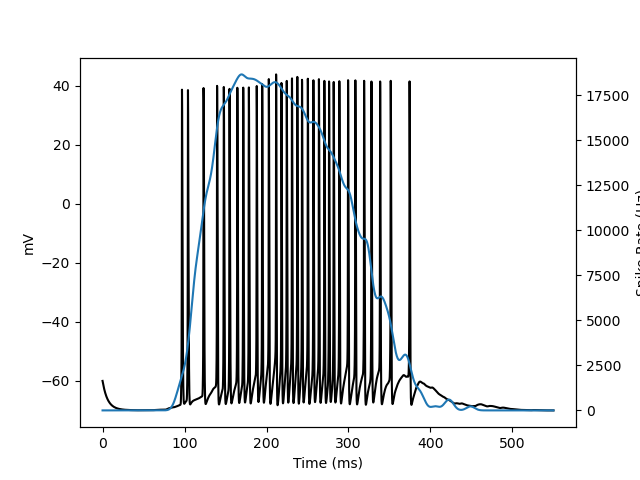

In [11]:
if calc_rates:
    st = np.mean(spike_rates[1.0][1.0], axis=(0, 1)) 
    ex_rate_fig, ex_rate_ax = plt.subplots(1)
    ex_rate_ax_right = ex_rate_ax.twinx()
    ex_rate_ax.plot(vm_xaxis, soma_vm[1.0][1.0][0, 0, 3], c="black")
    ex_rate_ax_right.plot(vm_xaxis, st[3] * rate_mul)
    ex_rate_ax.set_ylabel("mV")
    ex_rate_ax_right.set_ylabel("Spike Rate (Hz)")
    ex_rate_ax.set_xlabel("Time (ms)")

Impact of rho on DSI = 1.55


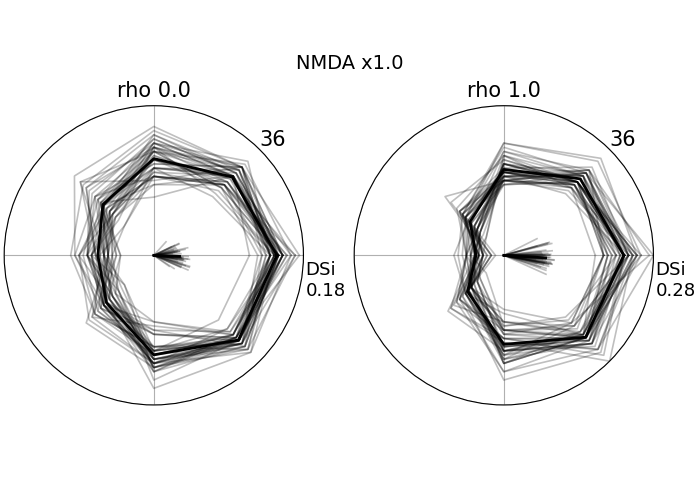

In [12]:
rate_mode = False
factor = 1.

if rate_mode and assert_calc_rates():
    max_spikes = np.max([np.max(r) for r in net_peak_spike_rates[factor].values()])
else:
    max_spikes = np.max([r["spikes"] for r in metrics[factor].values()])
    
rho_dsi_impact = np.mean(metrics[factor][1.0]["avg_DSi"]) / np.mean(metrics[factor][0.0]["avg_DSi"])
print("Impact of rho on DSI = %.2f" % rho_dsi_impact)

focus_polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
focus_polar_ax = [
    polar(
        (m["spikes"]
         if not rate_mode 
         else net_peak_spike_rates[factor][rho].reshape(len(idxs), 1, 8)),
        dir_labels,
        title="rho " + str(rho),
        radius=max_spikes,
        # radius=50,
        net_shadows=False,
        fig=focus_polar_fig,
        sub_loc=(1, n_cols, loc + 1),
        title_metrics=False,
    )
    for loc, (rho, m) in enumerate(metrics[factor].items())
]
focus_polar_fig.suptitle("NMDA x%.1f" % (factor), fontsize=14)
focus_polar_fig.set_layout_engine("compressed")
rate_lbl = "_spkrate" if rate_mode else ""
for ext in [".png", ".svg"]:
    focus_polar_fig.savefig(
        os.path.join(fig_path, "NMDA_x%.1f_polars%s%s" % (factor, rate_lbl, ext)), bbox_inches="tight")

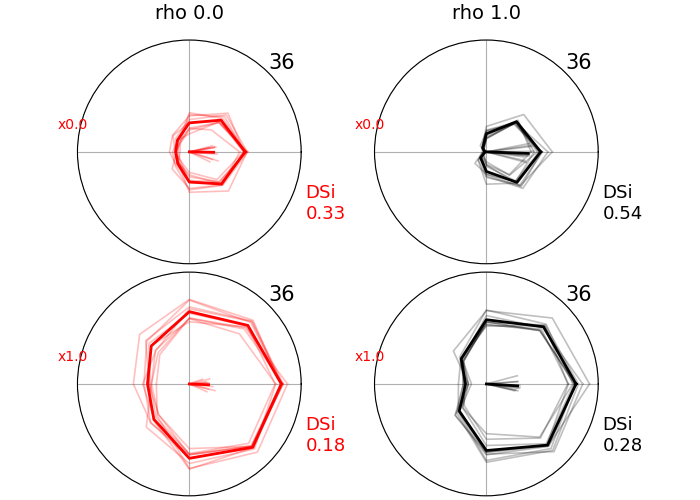

In [13]:
display_factors = factors
rate_mode = False
colours = ["red", "black"]

if rate_mode and assert_calc_rates():
    max_spikes = np.max([np.max(r) for s in display_factors for r in net_peak_spike_rates[s].values()])
else:
    max_spikes = np.max([r["spikes"] for s in display_factors for r in metrics[s].values()])
    
polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_factors))
splits = int(np.ceil(len(display_factors) / max_rows))
n_cols = len(rhos) * splits
polar_ax = []
for i, factor in enumerate(display_factors):
    row = i % max_rows
    subcol = i // max_rows
    for j, (rho, m) in enumerate(metrics[factor].items()):
        polar_ax.append(polar(
            (m["spikes"]
             if not rate_mode 
             else net_peak_spike_rates[factor][rho].reshape(len(idxs), 1, 8)),
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=True,
            fig=polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            dsi_tag_deg=-30,
            dsi_tag_mult=1.2,
            avg_colour=colours[j],
            shadow_alpha=0.25,
            shadow_linewidth=1.2,
        ))
        polar_ax[-1].text(np.radians(170), max_spikes * 1.2, ("x" + str(factor)), c="red")

for i in range(len(rhos)):
    polar_ax[i].set_title("rho %.1f" % rhos[i], fontsize=14, pad=15)

polar_fig.set_layout_engine("compressed")

lbl = "many" if len(display_factors) > 4 else "_".join(map(str, display_factors)).replace(".", "p")
rate_lbl = "_spkrate" if rate_mode else ""
for ext in [".png", ".svg"]:
    polar_fig.savefig(
        os.path.join(fig_path, "polar_grid_%s%s%s" % (lbl, rate_lbl, ext)), bbox_inches="tight")

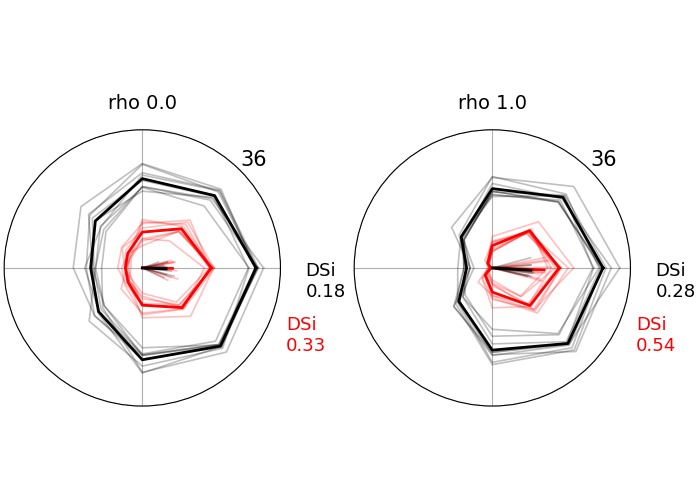

In [14]:
display_factors = factors
rate_mode = False
colours = ["red", "black"]

if rate_mode and assert_calc_rates():
    max_spikes = np.max([np.max(r) for s in display_factors for r in net_peak_spike_rates[s].values()])
else:
    max_spikes = np.max([r["spikes"] for s in display_factors for r in metrics[s].values()])
    
overlay_polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
overlay_polar_ax = []
for i, factor in enumerate(display_factors):
    for j, (rho, m) in enumerate(metrics[factor].items()):
        ax = None if not i else overlay_polar_ax[j]
        plr_ax = polar(
            (m["spikes"]
             if not rate_mode 
             else net_peak_spike_rates[factor][rho].reshape(len(idxs), 1, 8)),
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=True,
            fig=overlay_polar_fig,
            ax=ax,
            sub_loc=(1, n_cols, j + 1),
            dsi_tag_deg=-30,
            dsi_tag_mult=1.2,
            avg_colour=colours[i],
            shadow_alpha=0.25,
            shadow_linewidth=1.2,
        )
        if ax is None: overlay_polar_ax.append(plr_ax)

for i in range(len(rhos)):
    overlay_polar_ax[i].set_title("rho %.1f" % rhos[i], fontsize=14, pad=15)

overlay_polar_fig.set_layout_engine("compressed")

lbl = "many" if len(display_factors) > 4 else "_".join(map(str, display_factors)).replace(".", "p")
rate_lbl = "_spkrate" if rate_mode else ""
for ext in [".png", ".svg"]:
    overlay_polar_fig.savefig(
        os.path.join(fig_path, "overlay_polar_grid_%s%s%s" % (lbl, rate_lbl, ext)), bbox_inches="tight")

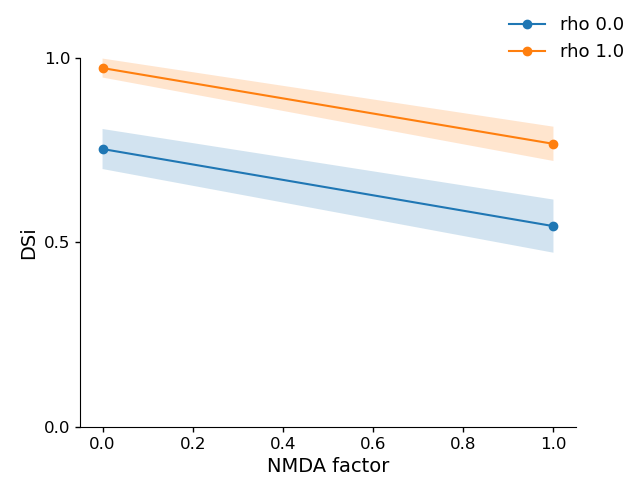

In [15]:
rate_mode = False
pn_mode = True

def calc_pn_tuning(resp, _dirs):
    # first dim of resp is direction, the rest can be organized into cells/trials however
    out_shape = resp.shape[1:]

    pd = resp[pref_idx].flatten()
    nd = resp[null_idx].flatten()
    DSi = (pd - nd) / pd
    theta = np.zeros_like(DSi)

    return DSi.reshape(out_shape), theta.reshape(out_shape)

dsi_fig, dsi_ax = plt.subplots(1)

tuning_funs = {"vec": calc_tuning, "pn": calc_pn_tuning}
titration_dsis = {"vec": {}, "pn": {}}
for kind, tds in titration_dsis.items():
    tuning = tuning_funs[kind]
    for rho in rhos:
        tds[rho] = {"nets": [], "avg": [], "std": []}
        for factor in factors:
            if rate_mode and assert_calc_rates():
                net_dsis, net_thetas = tuning(net_peak_spike_rates[factor][rho].T, dir_labels)
            else:
                # net_dsis = metrics[factor][rho]["avg_DSi"]
                # net_thetas = metrics[factor][rho]["avg_theta"]  # NOTE: currently unused
                net_dsis, net_thetas = tuning(metrics[factor][rho]["spikes"].sum(axis=1).T, dir_labels)
            tds[rho]["nets"].append(net_dsis)
            tds[rho]["avg"].append(np.mean(net_dsis))
            tds[rho]["std"].append(np.std(net_dsis))
        tds[rho] = {m: np.array(v) for m, v in tds[rho].items()}
        tds[rho]["nets"] = tds[rho]["nets"].T
        if (kind == "pn" and pn_mode) or (kind == "vec" and not pn_mode):
            dsi_ax.fill_between(
                factors, 
                tds[rho]["avg"] + tds[rho]["std"],
                tds[rho]["avg"] - tds[rho]["std"],
                alpha=0.2
            )
            dsi_ax.plot(factors, tds[rho]["avg"], marker="o", label="rho " + str(rho))
        
dsi_ax.set_ylabel("DSi", fontsize=14)
dsi_ax.set_xlabel("NMDA factor", fontsize=14)
if pn_mode:
    dsi_ax.set_ylim(0, 1.0)
    dsi_ax.set_yticks([0, 0.5, 1.0])
else:
    dsi_ax.set_ylim(0, 0.5)
    dsi_ax.set_yticks([0, 0.25, 0.5])

dsi_fig.legend(frameon=False, fontsize=13)
clean_axes(dsi_ax, ticksize=12)
for ext in [".png", ".svg"]:
    dsi_fig.savefig(os.path.join(fig_path, "dsi_vs_NMDA_factor%s" % (ext)), bbox_inches="tight")

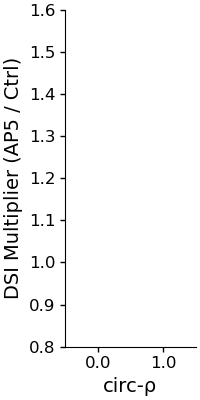

In [16]:
pn_mode = False

k = "pn" if pn_mode else "vec"

# make swarm plots of the DSI scales between NMDA on and off, as well as the impact of
# rho when NMDA is on and off (on DSI, null, and pre spiking)
dsi_scale_fig, dsi_scale_ax = plt.subplots(1, figsize=(2, 4))
dsi_scale_df = pd.DataFrame.from_dict(
    {str(r): titration_dsis[k][r]["nets"][:, 0] / titration_dsis[k][r]["nets"][:, 1] for r in rhos})
palette = {"0.0": "red", "1.0": "black"}
sns.swarmplot(dsi_scale_df, ax=dsi_scale_ax, palette=palette)

dsi_scale_ax.set_ylim(0.8, 1.6)
dsi_scale_ax.set_xlabel("circ-ρ", fontsize=14)
dsi_scale_ax.set_ylabel("DSI Multiplier (AP5 / Ctrl)", fontsize=14)
clean_axes(dsi_scale_ax, ticksize=12)
dsi_scale_fig.set_layout_engine("compressed")

pn_lbl = "pn_" if pn_mode else ""
metric_lbl = "rate" if rate_mode else "spk"
for ext in [".png", ".svg"]:
    dsi_scale_fig.savefig(
        os.path.join(fig_path, "%sdsi_%s_multiplier_swarm%s" % (pn_lbl, metric_lbl, ext)), bbox_inches="tight")

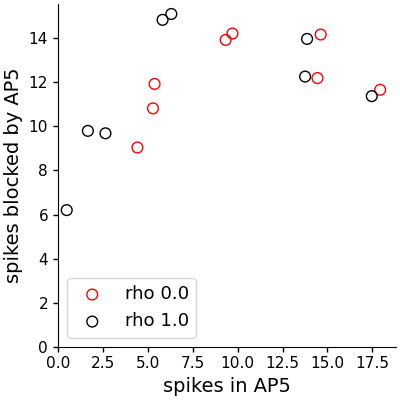

In [17]:
rate_mode = False

score_lbl = "rate" if rate_mode else "spikes"
dir_scatter_fig, dir_scatter_ax = plt.subplots(1, figsize=(4, 4))

clrs = {0.: "red", 1.:"black"}

for rho in rhos:
    if rate_mode and assert_calc_rates():
        ap5 = np.mean(net_peak_spike_rates[0.0][rho], axis=0)
        ctrl = np.mean(net_peak_spike_rates[1.0][rho], axis=0)
    else:
        ap5 = np.mean(metrics[0.0][rho]["spikes"], axis=(0, 1))
        ctrl = np.mean(metrics[1.0][rho]["spikes"], axis=(0, 1))
    blocked = ctrl - ap5
    dir_scatter_ax.scatter(
        ap5, blocked, s=60, facecolors="none", edgecolors=clrs[rho], label="rho %.1f" % rho)
    
dir_scatter_ax.set_xlim(0)
dir_scatter_ax.set_ylim(0)

dir_scatter_ax.set_xlabel("%s in AP5" % score_lbl, fontsize=14)
dir_scatter_ax.set_ylabel("%s blocked by AP5" % score_lbl, fontsize=14)
dir_scatter_ax.legend(frameon=True, fontsize=13)

clean_axes(dir_scatter_ax)
dir_scatter_fig.set_layout_engine("compressed")

for ext in [".png", ".svg"]:
    dir_scatter_fig.savefig(
        os.path.join(fig_path, "%s_blocked_by_ap5%s" % (score_lbl, ext)), bbox_inches="tight")

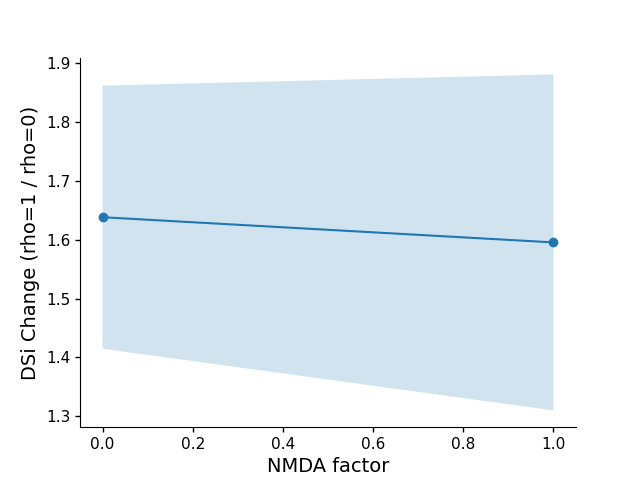

In [18]:
pn_mode = False

k = "pn" if pn_mode else "vec"

rho_dsi_effect_fig, rho_dsi_effect_ax = plt.subplots(1)
dsi_effect_nets = titration_dsis[k][1.0]["nets"] / titration_dsis[k][0.0]["nets"]
dsi_effect_avg = np.mean(dsi_effect_nets, axis=0)
dsi_effect_std = np.std(dsi_effect_nets, axis=0)

rho_dsi_effect_ax.fill_between(
    factors, 
    dsi_effect_avg + dsi_effect_std,
    dsi_effect_avg - dsi_effect_std,
    alpha=0.2
)
rho_dsi_effect_ax.plot(factors, dsi_effect_avg, marker="o")

rho_dsi_effect_ax.set_ylabel("DSi Change (rho=1 / rho=0)", fontsize=14)
rho_dsi_effect_ax.set_xlabel("NMDA factor", fontsize=14)
# rho_dsi_effect_ax.set_xscale("log")

clean_axes(rho_dsi_effect_ax)
pn_lbl = "pn_" if pn_mode else ""
for ext in exts:
    rho_dsi_effect_fig.savefig(os.path.join(
        fig_path, "NMDA_%sdsi_effect_of_rho%s" % (pn_lbl, ext)), bbox_inches="tight")

In [19]:
avg_spikes = {
    fac: {rho: np.mean(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}
std_spikes = {
    fac: {rho: np.std(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}
sem_spikes = map_data(lambda sd: sd / np.sqrt(sd.shape[0]), std_spikes)

if calc_rates:
    avg_net_peak_spike_rates = map_data(lambda pr: pr.mean(axis=0), net_peak_spike_rates)
    std_net_peak_spike_rates = map_data(lambda pr: pr.std(axis=0), net_peak_spike_rates)
    sem_net_peak_spike_rates = map_data(lambda pr: pr / np.sqrt(pr.shape[0]), std_net_peak_spike_rates)

dirs_180 = np.array([ana.scale_180_from_360(d) for d in  dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
if np.max(dirs_180) < 180:
    wrap_circ = lambda ds: np.r_[ds, ds[0]]
    circ_180 = np.r_[dirs_180_sorted, -dirs_180_sorted[0]]
else:
    wrap_circ = lambda ds: np.r_[ds[-1], ds] 
    circ_180 = np.r_[-dirs_180_sorted[-1], dirs_180_sorted] 

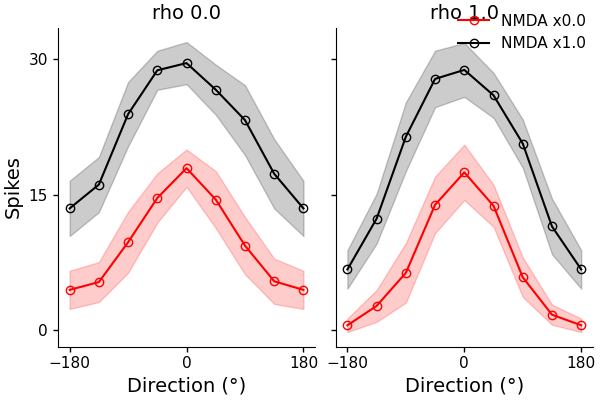

In [20]:
sem_mode = False
mark_mode = True
data_ls = "-"
show_vonmises = False
err = sem_spikes if sem_mode else std_spikes

def vonmises(x, rmax, k, mu):
    return rmax * np.exp(k * np.cos(x - mu)) / np.exp(k)

tuning_fig, tuning_ax = plt.subplots(1, len(rhos), sharey=True, figsize=(6, 4))
for i, (ax, rho) in enumerate(zip(tuning_ax, rhos)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title("rho " + str(rho), fontsize=14)
    for factor in factors:
        lbl = ("NMDA x" + str(factor)) if not i else None
        m_kwargs = dict(
            marker="o", markerfacecolor="none", markeredgecolor=clrs[factor]) if mark_mode else {}
        circ_err = wrap_circ(err[factor][rho][dir_sort])
        circ_avg = wrap_circ(avg_spikes[factor][rho][dir_sort])
        params, cov = curve_fit(vonmises, np.radians(circ_180), circ_avg)
        ax.fill_between(circ_180, circ_avg + circ_err, circ_avg - circ_err,
                        color=clrs[factor], alpha=0.2)
        ax.plot(circ_180, circ_avg, c=clrs[factor], label=lbl, ls=data_ls, **m_kwargs)
        if show_vonmises:
            vm_xaxis = np.linspace(circ_180[0], circ_180[-1], 64)
            vm = vonmises(np.radians(vm_xaxis), *params)
            ax.plot(vm_xaxis, vm, c=clrs[factor], ls="--")
    ax.set_xticks([-180, 0, 180])
    
tuning_ax[0].set_yticks([0, 15, 30])
tuning_ax[0].set_ylabel("Spikes", fontsize=14)
tuning_fig.legend(frameon=False, fontsize=11)
clean_axes(tuning_ax)
tuning_fig.set_layout_engine("compressed")
for ext in exts:
    tuning_fig.savefig(os.path.join(fig_path, "NMDA_tuning%s"  % (ext)), bbox_inches="tight")

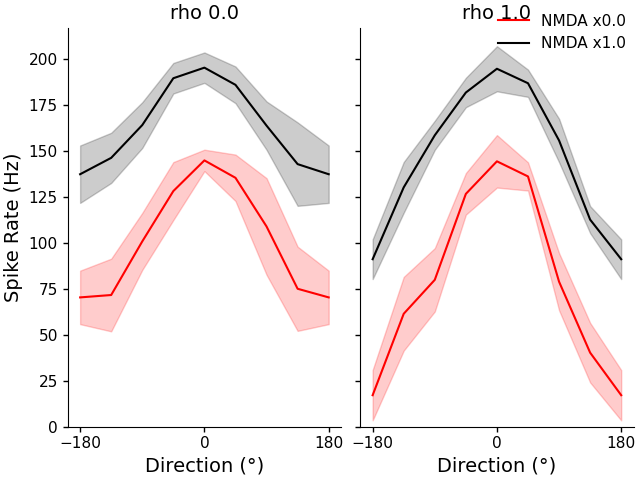

In [21]:
if calc_rates:
    sem_mode = False
    mark_mode = False
    err = sem_net_peak_spike_rates if sem_mode else std_net_peak_spike_rates
    
    rate_tuning_fig, rate_tuning_ax = plt.subplots(1, len(rhos), sharey=True)
    for i, (ax, rho) in enumerate(zip(rate_tuning_ax, rhos)):
        ax.set_xlabel("Direction (°)", fontsize=14)
        ax.set_title("rho " + str(rho), fontsize=14)
        for factor in factors:
            lbl = ("NMDA x" + str(factor)) if not i else None
            m_kwargs = dict(
                marker="o", markerfacecolor="none", markeredgecolor=clrs[factor]) if mark_mode else {}
            circ_err = wrap_circ(err[factor][rho][dir_sort])
            circ_avg = wrap_circ(avg_net_peak_spike_rates[factor][rho][dir_sort])
            ax.fill_between(circ_180, circ_avg + circ_err, circ_avg - circ_err,
                            color=clrs[factor], alpha=0.2)
            ax.plot(circ_180, circ_avg, c=clrs[factor], label=lbl, **m_kwargs)
        ax.set_xticks([-180, 0, 180])
    
    rate_tuning_ax[0].set_ylim(0)
    rate_tuning_ax[0].set_ylabel("Spike Rate (Hz)", fontsize=14)
    rate_tuning_fig.legend(frameon=False, fontsize=11)
    clean_axes(rate_tuning_ax)
    rate_tuning_fig.set_layout_engine("compressed")
    for ext in exts:
        rate_tuning_fig.savefig(os.path.join(fig_path, "NMDA_rate_tuning%s"  % (ext)), bbox_inches="tight")

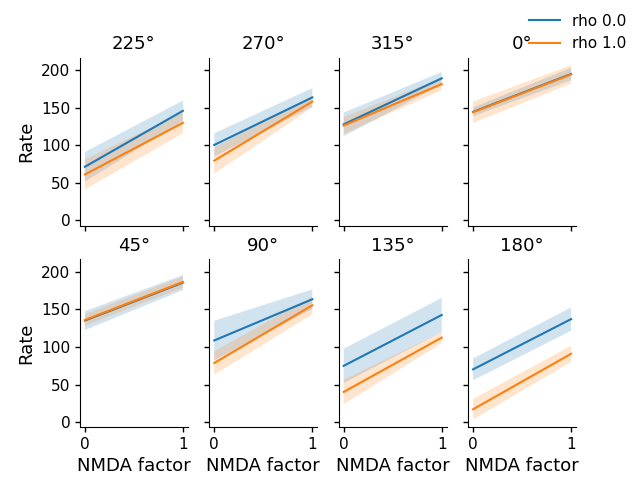

In [22]:
rate_mode = True
score_lbl = "Rate" if rate_mode else "Spikes"

dir_grid_fig, dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)
score_avgs = avg_net_peak_spike_rates if rate_mode else avg_spikes
score_stds = std_net_peak_spike_rates if rate_mode else std_spikes

i = 0
for row in dir_grid_ax:
    row[0].set_ylabel(score_lbl, fontsize=13)
    for ax in row:
        for rho in rhos:
            avgs = np.array([score_avgs[factor][rho][i] for factor in factors])
            stds = np.array([score_stds[factor][rho][i] for factor in factors])
            lbl = ("rho " + str(rho)) if not i else None
            ax.fill_between(factors, avgs + stds, avgs - stds, alpha=0.2)
            ax.plot(factors, avgs, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_grid_ax.T:
    col[-1].set_xlabel("NMDA factor", fontsize=13)

# dir_grid_ax[0, 0].invert_xaxis()
# dir_grid_ax[0, 0].set_xscale("log")
dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_grid_ax)
for ext in exts:
    dir_grid_fig.savefig(os.path.join(
        fig_path, "NMDA_dir_%s_grid%s" % (score_lbl, ext)), bbox_inches="tight")

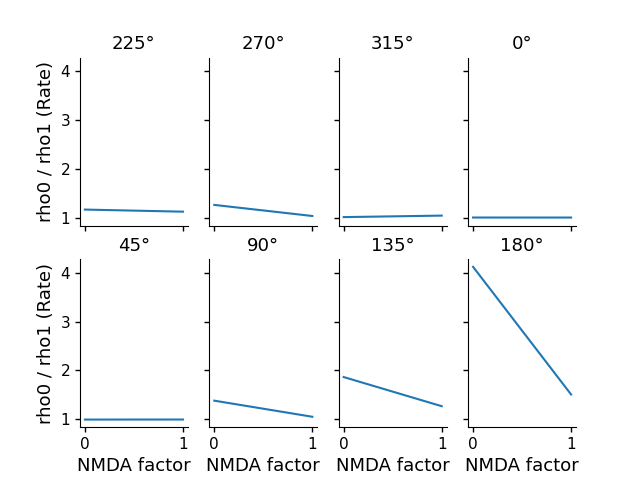

In [23]:
dir_mult_grid_fig, dir_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_mult_grid_ax:
    row[0].set_ylabel("rho0 / rho1 (%s)" % score_lbl, fontsize=13)
    for ax in row:
        rho0_spks = np.array([score_avgs[factor][0.0][i] for factor in factors])
        rho1_spks = np.array([score_avgs[factor][1.0][i] for factor in factors])
        ax.plot(factors, rho0_spks / rho1_spks)
        ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_mult_grid_ax.T:
    col[-1].set_xlabel("NMDA factor", fontsize=13)
        
clean_axes(dir_mult_grid_ax)
for ext in exts:
    dir_mult_grid_fig.savefig(os.path.join(
        fig_path, "NMDA_dir_%s_effect_of_rho_grid%s" % (score_lbl, ext)), bbox_inches="tight")

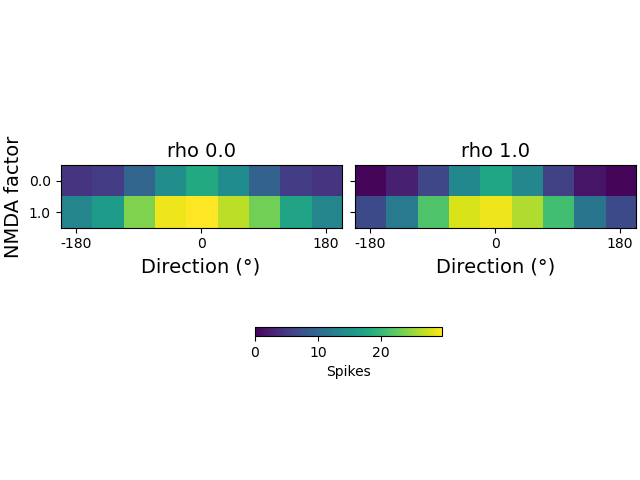

In [24]:
rate_mode = False

score_lbl = "Rate" if rate_mode else "Spikes"
score_avgs = avg_net_peak_spike_rates if rate_mode else avg_spikes

tuning_mat_fig, tuning_mat_ax = plt.subplots(1, 2, sharey=True)

avg_score_mats = {
    rho: np.stack(
        [wrap_circ(score_avgs[factor][rho][dir_sort]) for factor in factors], axis=0)
    for rho in rhos
}
avg_max_score = np.max([m.max() for m in avg_score_mats.values()])
avg_score_imgs = {}

vmax = avg_max_score
# vmax = 20.0

for i, (ax, rho) in enumerate(zip(tuning_mat_ax, rhos)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title("rho " + str(rho), fontsize=14)
    avg_score_imgs[rho] = ax.imshow(avg_score_mats[rho], vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks([0, 4, 8])
    ax.set_xticklabels([-180, 0, 180])
    ax.set_yticks(range(len(factors)))
    ax.set_yticklabels(factors)
    
tuning_mat_ax[0].set_ylabel("NMDA factor", fontsize=14)
tuning_mat_fig.colorbar(
    avg_score_imgs[rhos[-1]], ax=tuning_mat_ax, label=score_lbl, orientation="horizontal")
tuning_mat_fig.set_layout_engine("compressed")
for ext in exts:
    tuning_mat_fig.savefig(os.path.join(
        fig_path, "NMDA_tuning_matrices%s" % (ext)), bbox_inches="tight")

In [25]:
close_button()

fraction of nmda spikes per bin:
 [0.   0.   0.42 0.51 0.51 0.6  0.67 0.8  0.82 0.81 1.  ]


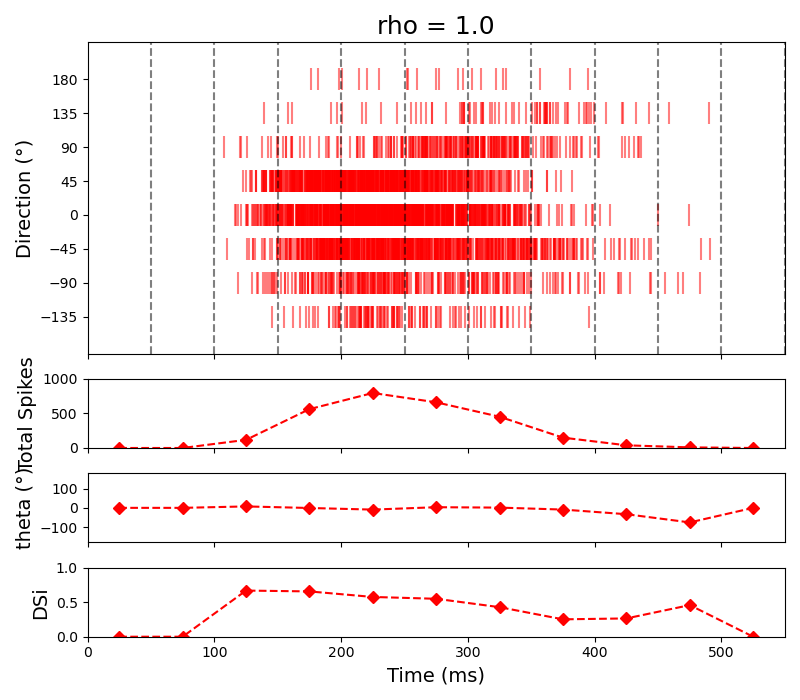

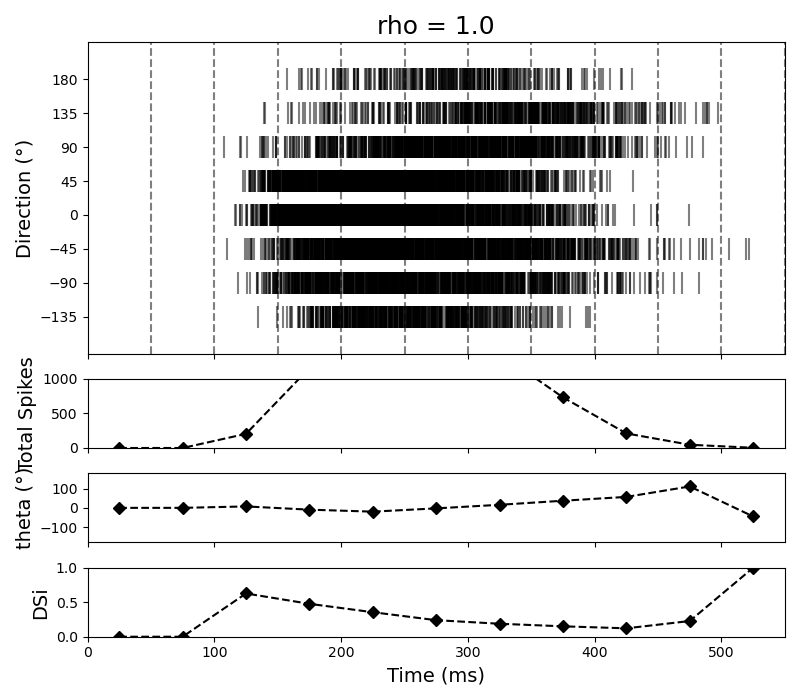

In [26]:
# v1000 SR alignment offsets (ms): [54.4 43.  12.6  0.  15.4 42.8 52.3 43.3]
dir_field_offsets = [10.9, 25.7, 36.4, 22.5, 6.6, 5.6, 1.1, 0.]  # ms
lh_off_sr_alignments = [54.4, 43., 12.6, 0., 15.4, 42.8, 52.3, 43.3] # from LH offset model data (recalc for 0 GABA titration)
ei_sr_alignments_thresh8 = [12.1, 39.6, 61.7, 34.5, 10.9, 36.7, 39.9, 0.]
ei_sr_alignments_thresh1 = [9.4, 37.6, 59.8, 25., 0., 35.4, 68.7, 16.6]
ei_sr_alignments_thresh2p5 = [8.4, 33.6, 55.5, 25.2, 0., 31.1, 51.7, 14.]
# alignments = ei_sr_alignments_thresh8
# alignments = ei_sr_alignments_thresh1
alignments = ei_sr_alignments_thresh2p5
rho = 1. 
ap5_rasters_fig, ap5_binned = spike_rasters(
    d[0.0],
    dir_labels,
    rho=rho,
    bin_ms=50,
    offsets=alignments,
    colour="red",
    spike_vmax=1000,
    figsize=(8, 7),
)
ctrl_rasters_fig, ctrl_binned = spike_rasters(
    d[1.0],
    dir_labels,
    rho=rho,
    bin_ms=50,
    offsets=alignments,
    colour="black",
    spike_vmax=1000,
    figsize=(8, 7),
)

nmda_total_frac = (
    (ctrl_binned[1.0]["total_spks"] - ap5_binned[1.0]["total_spks"])
    / (ctrl_binned[1.0]["total_spks"] + 1e-6))
print("fraction of nmda spikes per bin:\n", nmda_total_frac.round(decimals=2))

name = os.path.join(fig_path, "ap5_rasters_%s" % ("%.2f" % rho).replace(".", "p"))
for ext in [".png", ".svg"]:
    ap5_rasters_fig.savefig(name + ext, bbox_inches="tight")
    
name = os.path.join(fig_path, "ctrl_rasters_%s" % ("%.2f" % rho).replace(".", "p"))
for ext in [".png", ".svg"]:
    ctrl_rasters_fig.savefig(name + ext, bbox_inches="tight")

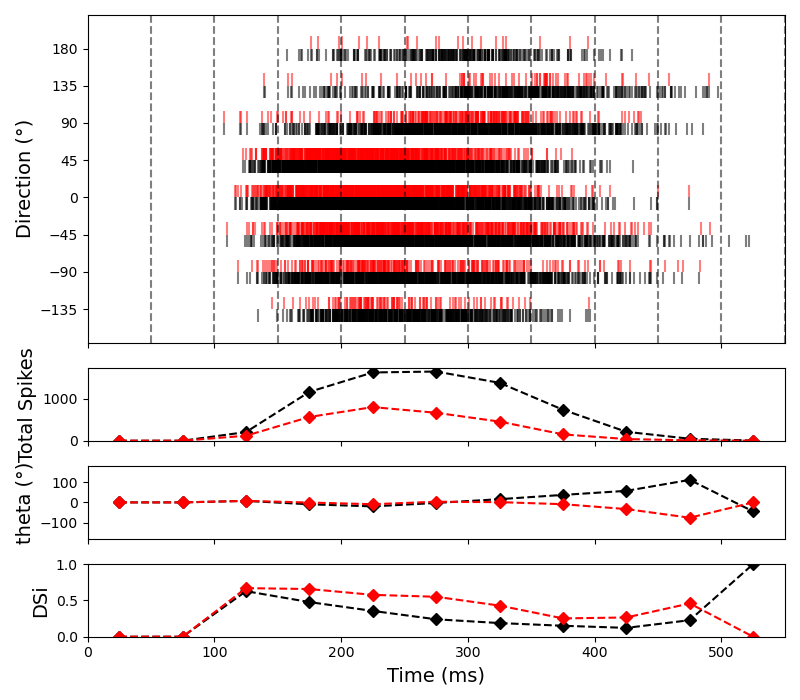

In [27]:
comp_spks = {
    "CTRL": np.stack([d[1.0][1.0][i]["soma"]["Vm"] for i in idxs], axis=0),
    "AP5": np.stack([d[0.0][1.0][i]["soma"]["Vm"] for i in idxs], axis=0),
}
comp_rasters_fig, comp_binned = comp_spike_rasters(
    comp_spks,
    dir_labels,
    vm_dt,
    bin_ms=50,
    offsets=alignments,
    palette=["black", "red"],
    # spike_vmax=1000,
    figsize=(8, 7),
)

name = os.path.join(fig_path, "ctrl_vs_ap5_rasters_%s" % ("%.2f" % rho).replace(".", "p"))
for ext in [".png", ".svg"]:
    comp_rasters_fig.savefig(name + ext, bbox_inches="tight")

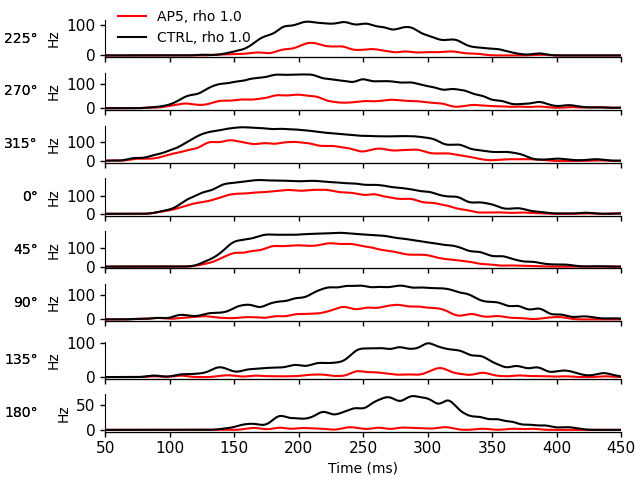

In [28]:
incl_scaled = False
if calc_rates:
    pad = [nearest_index(vm_xaxis, algn) for algn in alignments]
    aligned_avg_spike_rates = {
        factor: {
            rho: np.array([
                # np.r_[avg_spike_rates[factor][rho][i, pad[i]:], np.zeros(pad[i])]
                np.r_[np.zeros(pad[i]), avg_spike_rates[factor][rho][i, pad[i]:]]
                for i in range(len(dir_labels))
            ])
            for rhos in rhos
        }
        for factor in factors
    }

    display_rhos = rhos
    display_rhos = [1.0]
    rho_styles = {0.0: "--", 1.0: "-"}
    ymax = None
    
    dir_rates_fig, dir_rates_ax = plt.subplots(len(dir_labels), sharex=True)
    
    for rho in display_rhos:
        for factor in factors:
            for i, ax in enumerate(dir_rates_ax):
                ax.plot(
                    vm_xaxis,
                    avg_spike_rates[factor][rho][i],
                    linestyle=rho_styles[rho],
                    c=clrs[factor],
                    label=("%s, rho %s" % ("AP5" if factor == 0.0 else "CTRL", str(rho))
                          ) if not i else None
                )
                if ymax is not None: ax.set_ylim(-3, ymax)
                dummy_yaxis_label(ax, "%s°" % dir_labels[i], offset=-0.12)
                ax.set_ylabel("Hz")
        if incl_scaled:
            scale = avg_peak_spike_rates[1.0][rho] / avg_peak_spike_rates[0.0][rho]
            ap5_scaled = avg_spike_rates[0.0][rho] * scale.reshape(-1, 1)
            for i, ax in enumerate(dir_rates_ax):
                ax.plot(
                    vm_xaxis,
                    ap5_scaled[i],
                    linestyle=rho_styles[rho],
                    c="blue",
                    label=("AP5 Scaled, rho %s" % rho) if not i else None,
                )
    
    dir_rates_ax[-1].set_xlim(50, 450)
    dir_rates_ax[-1].set_xlabel("Time (ms)")
    dir_rates_ax[0].legend(frameon=False)
    clean_axes(dir_rates_ax)
    dir_rates_fig.set_layout_engine("compressed")

    scaled_lbl = "_w_scaled" if incl_scaled else ""
    for ext in exts:
        dir_rates_fig.savefig(
            os.path.join(fig_path, "dir_avg_spike_rates%s%s"  % (scaled_lbl, ext)), bbox_inches="tight")

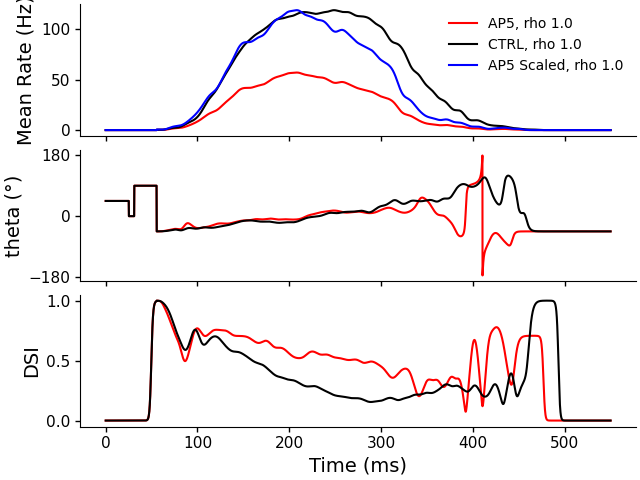

In [29]:
if calc_rates:
    incl_scaled = True
    display_rhos = rhos
    display_rhos = [1.0]
    rho_styles = {0.0: "--", 1.0: "-"}
    
    aligned_avg_rate_tuning = map_data(lambda a: calc_tuning(a, dir_labels), aligned_avg_spike_rates)
    
    aligned_rate_tuning_fig, aligned_rate_tuning_ax = plt.subplots(3, sharex=True)
    
    for rho in display_rhos:
        for factor in factors:
            aligned_rate_tuning_ax[0].plot(
                vm_xaxis,
                aligned_avg_spike_rates[factor][rho].mean(axis=0),
                linestyle=rho_styles[rho],
                c=clrs[factor],
                label="%s, rho %s" % ("AP5" if factor == 0.0 else "CTRL", str(rho)),
            )
            aligned_rate_tuning_ax[1].plot(
                vm_xaxis,
                aligned_avg_rate_tuning[factor][rho][1],
                linestyle=rho_styles[rho],
                c=clrs[factor],
                # label="%s, rho %s" % ("AP5" if factor == 0.0 else "CTRL", str(rho)),
            )
            aligned_rate_tuning_ax[2].plot(
                vm_xaxis,
                aligned_avg_rate_tuning[factor][rho][0],
                linestyle=rho_styles[rho],
                c=clrs[factor],
            )
    
        if incl_scaled:
            scale = (aligned_avg_spike_rates[1.0][rho].mean(axis=0).max()
                     / aligned_avg_spike_rates[0.0][rho].mean(axis=0).max())
            ap5_scaled = aligned_avg_spike_rates[0.0][rho].mean(axis=0) * scale
            aligned_rate_tuning_ax[0].plot(
                vm_xaxis,
                ap5_scaled,
                linestyle=rho_styles[rho],
                c="blue",
                label="AP5 Scaled, rho %s" % rho,
            )
    
    aligned_rate_tuning_ax[1].set_yticks([-180, 0, 180])
    aligned_rate_tuning_ax[2].set_yticks([0, 0.5, 1.])
    # aligned_rate_tuning_ax[-1].set_xlim(50, 450)
    
    aligned_rate_tuning_ax[0].set_ylabel("Mean Rate (Hz)", fontsize=14)
    aligned_rate_tuning_ax[1].set_ylabel("theta (°)", fontsize=14)
    aligned_rate_tuning_ax[2].set_ylabel("DSI", fontsize=14)
    aligned_rate_tuning_ax[-1].set_xlabel("Time (ms)", fontsize=14)
    
    aligned_rate_tuning_ax[0].legend(frameon=False)
    clean_axes(aligned_rate_tuning_ax)
    aligned_rate_tuning_fig.set_layout_engine("compressed")
    
    for ext in exts:
        aligned_rate_tuning_fig.savefig(
            os.path.join(fig_path, "aligned_rate_tuning_%s%s"  % (scaled_lbl, ext)), bbox_inches="tight")

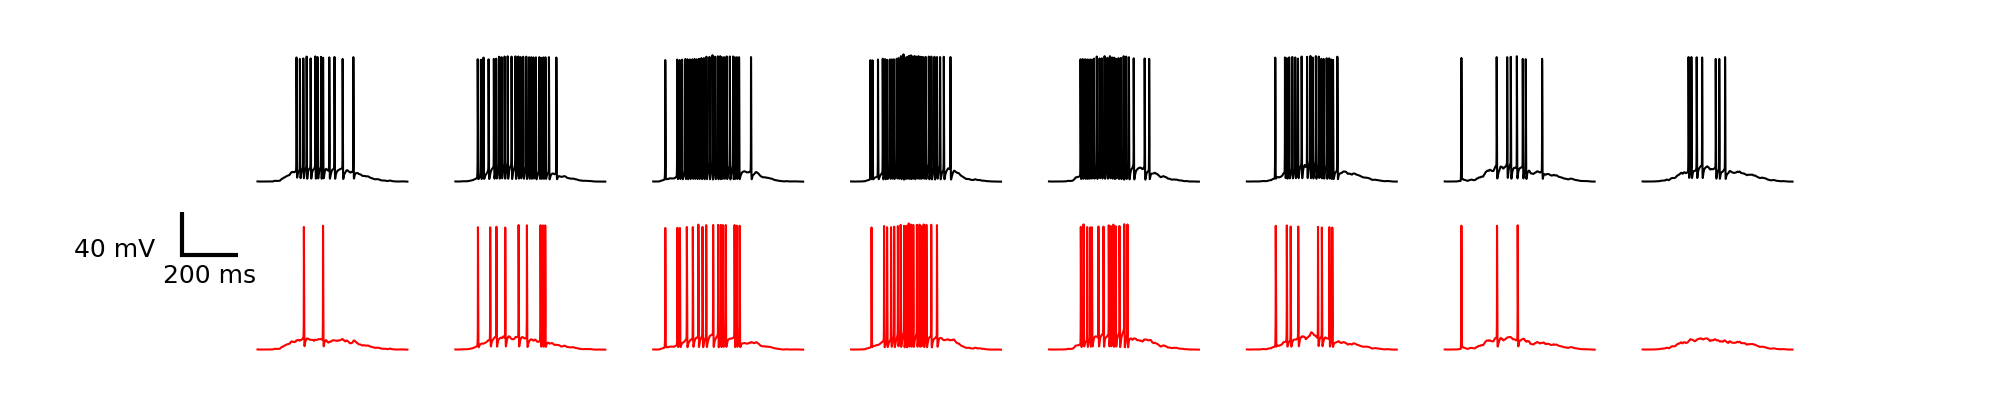

In [30]:
rho = 1.0
net = 0
trial = 0
display_factors = list(reversed(factors))
# display_factors = [1.0]

vm_pts = d[factors[0]][rho][net]["soma"]["Vm"].shape[-1]
vm_xaxis = np.linspace(0, vm_pts * d[factors[0]][rho][net]["params"]["dt"], vm_pts)

trial_vm_fig, trial_vm_ax = plt.subplots(len(display_factors), len(dir_labels), sharex=True, sharey=True, figsize=(20, 4))
trial_vm_ax = np.expand_dims(trial_vm_ax, 0) if trial_vm_ax.ndim == 1 else trial_vm_ax
for i, factor in enumerate(display_factors):
    for j in range(len(dir_labels)):
        trial_vm_ax[i, j].plot(vm_xaxis[300:], d[factor][rho][net]["soma"]["Vm"][trial, j, 300:], c=clrs[factor])
        trial_vm_ax[i, j].patch.set_alpha(0)

clean_axes(trial_vm_ax, remove_spines=["left", "right", "top", "bottom"])

sizex = 200
sizey = 40
add_scalebar(
    trial_vm_ax[-1, 0], 
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % sizex,
    labely="%i mV" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 150),
    textprops={"fontsize": 18},
)

cond_lbl = "_".join(factor_names[k] for k in display_factors)
name = os.path.join(fig_path, "vm_%s_rho%s_net%i_trial%i" % (cond_lbl, ("%.2f" % rho).replace(".", "p"), net, trial))
for ext in [".png", ".svg"]:
    trial_vm_fig.savefig(name + ext)